# Recurrent Neural Networks

We have already seen a recurrent neural network: the Hopfield-Tank network. However, this is not typically how they are thought of in the modern context. In this notebook we will go through recurrent neural networks more generally and discuss some of their implementations, limitations, and data types and tasks that they work well on. The *recurrent* implies that the output can *feed-back* again to the network as an input.

[IMG]

Notice that after the activation the data is given a path to flow back into input. How do we make sense of this? In the Hopfield-Tank network we applied this rule recursively until a stable point. For more generic neural networks we tend to visualise it as a sequence where input is fed in as x(t) and combined with output y(t-1). This is known as unrolling and it is our first clue that RNNs will work well with sequential data. Let's proceed in the normal way by defining our RNN cell.

In [2]:
mutable struct RNN
    Winput
    Whidden
    Woutput
    bhidden
    boutput
    fhidden
    foutput
    hidden
    function RNN(din, dhid, dout, fhid, fout)
        Winput = rand(Float32, dhid, din) .- 0.5
        Whidden = rand(Float32, dhid, dhid) .- 0.5
        Woutput = rand(Float32, dout, dhid) .- 0.5
        bhidden = rand(dhid) .- 0.5
        boutput = rand(dout) .- 0.5
        new(Winput, Whidden, Woutput, bhidden, boutput, fhid, fout, zeros(size(bhidden)))
    end
end

function reccur(RNN, input)
    RNN.hidden = RNN.bhidden .+ RNN.Whidden * RNN.hidden .+ RNN.Winput * input
    output = RNN.foutput.(RNN.Woutput * RNN.fhidden.(RNN.hidden) .+ RNN.boutput)
    return output
end

reccur (generic function with 1 method)

The reccurent neural network is a little bit different to the feed-forward network in that it has to accumulate the errors through each recursion. This poses some unique challenges, particularly with the gradient. The way we normally visualise the process to make it static is to "unroll" it. We apply the same cell block n times in a line so that it appears as a regular feedforward network.


[IMG]

Then, we calculate the loss function on this unrolled graph. There are a number of choices we can make here but the general form a recurrent neural network is to output states for each input. This creates a sequence of outputs which can be compared against some target sequence. The losses for each element of the sequence can then be accumulated and backpropagated through to calculate the gradients for the weights. Since each of the losses depend on the forward pass of that which came before it there is no way to make this process parallel; it is O(T) in sequence length. It is therefore very expensive.

Another problem that is common with RNNs is the exploding/vanishing gradient problem. The function is passed through itself many times. This leads to saturating behaviour in many of the common activiation functions. As a result gradients tend to be forced to zero (vanish) or become unbounded (explode). There are a number of regularisation techniques that have been developed to get around this problem. Let's have a look at it in action first. We will define some dummy data and train our recurrent neural network. We will see that we need to have very small learning rates to stabilise the enormous gradients that are generated. Run the following training function for a few different learning rates 

In [4]:
using Zygote, Plots
x = collect(0:0.01:pi/2);
y = sin.(x);
L(x, y) = sum((x.-y).^2)
f(rnn) = map(p -> reccur(rnn, p)[1], x)
grad(rnn) = gradient(rnn -> L(f(rnn), y), rnn)

grad (generic function with 1 method)

In [30]:
function untamed_gradients(eta, imax)
    rnn = RNN(1,5,1,tanh,tanh)
    for i = 1:imax
        g = grad(rnn)
        rnn.Winput = rnn.Winput .- eta * g[1][:Winput]
        rnn.Whidden = rnn.Whidden .- eta * g[1][:Whidden]
        rnn.Woutput = rnn.Woutput .- eta * g[1][:Woutput]
        rnn.bhidden = rnn.bhidden .- eta * g[1][:bhidden]
        rnn.boutput = rnn.boutput .- eta * g[1][:boutput]
        
        gvec = [g[1][:Winput], g[1][:Whidden], g[1][:Woutput], g[1][:bhidden], g[1][:boutput]]
        mags = round.(map(x -> sqrt(sum(x.^2)), gvec), digits=2)
        p = plot(x, vec(hcat(f(rnn)...)); label="Trained Sin")
        plot!(x, y; title="Fraction Completed: $(round(i/imax, digits=2))", label="True Sin")
        annotate!(0.2,1,mags[1])
        display(p)
        IJulia.clear_output(true)
    end
end

untamed_gradients (generic function with 1 method)

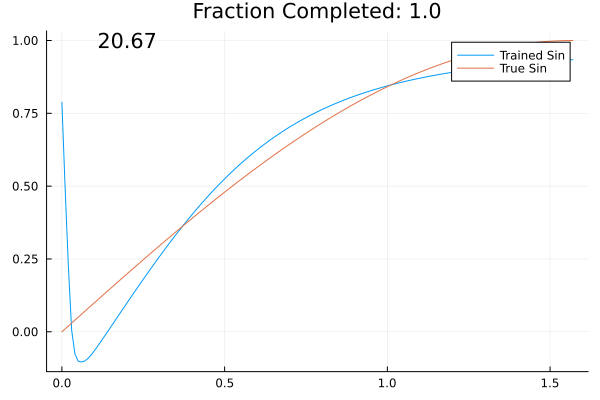

In [31]:
untamed_gradients(1e-5, 200)

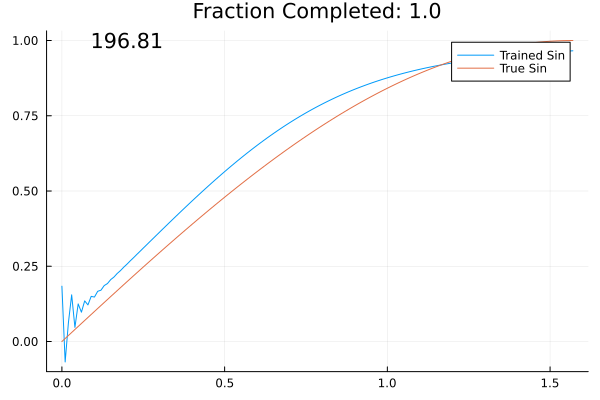

In [33]:
untamed_gradients(2e-4, 200)